# Characters

In [1]:
import os
from homoglypher.process_data import HomoglyphJSON
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preliminaries

Build a record for each font file. Each `.json` contains characters that share the same glyph

In [2]:
indir = "data_googlefonts"
fnames = os.listdir(indir)

records = []
for f in fnames:
    r = HomoglyphJSON(f, indir)
    records.append(r.record)

Compile into a big dataframe

In [3]:
fonts = pd.concat([r for r in records])
print(f"Number of entries: {len(fonts):,}")

Number of entries: 146,654


## Character pair metrics

When a font contains a character, how often does that character pair with another character in a homoglyph group? First, group by filename, then homoglyph, then decimal. Make a co-occurrence matrix and stack it. Return all nonzero pairs

In [4]:
grouped = (
    fonts
    .groupby(['FILE', 'GROUP', 'DEC'])
    .size()
    .unstack()
    .fillna(0)
)

coocc = grouped.T.dot(grouped)
np.fill_diagonal(coocc.values, 0)

Now we can stack the co-occurences and return a dataframe of character-to-character counts. From that, we'll filter out 0 values

In [5]:
pairs = pd.DataFrame(coocc.stack())
pairs = (
    pairs
    .reset_index(level=0)
    .rename(columns={'DEC': 'PAIR', 0: 'FONT_COUNT'})
    .reset_index()
)
pairs = pairs[pairs['FONT_COUNT'] > 0]

In [6]:
pairs.head(5)

,DEC,PAIR,FONT_COUNT
1,34,33,6.0
2,35,33,6.0
3,36,33,6.0
4,37,33,6.0
5,38,33,3.0


With the counts made, we can find the conditional probability of one character pairing with another (given their appearance in a particular font). First, create a long table that has a row for every character-character count

In [7]:
long = pairs[['DEC', 'PAIR']].apply(lambda x: np.repeat(x, pairs['FONT_COUNT']))

Now this can be fed through `pd.crosstab()`. As above, we'll also filter out 0 values

In [8]:
pair_probs = (
    pd.crosstab(long['DEC'], long['PAIR'], normalize='columns')
    .stack()
    .reset_index()
    .rename(columns={0: 'FONT_PROB'})
)
pair_probs = pair_probs[pair_probs['FONT_PROB'] > 0]

Now we can stick these probabilities back onto the dataframe of pairs

In [9]:
pairs = pd.merge(pairs, pair_probs)

## Pair counts

A quick overview of raw pair counts. Here are some highly occurent characters

In [10]:
quant = 0.95
high_quant = pairs['FONT_COUNT'].quantile(quant)

print(
    "The number of pairs:",
    f"\n+ Mean: {pairs['FONT_COUNT'].mean():.02f}",
    f"\n+ Standard deviation: {pairs['FONT_COUNT'].std():.02f}",
    f"\n+ Variance: {pairs['FONT_COUNT'].var():.02f}",
    f"\n+ {quant} quantile: {high_quant:.02f}"
)

The number of pairs: 
+ Mean: 4.67 
+ Standard deviation: 20.94 
+ Variance: 438.56 
+ 0.95 quantile: 6.00


In [11]:
pair_counts = (
    pairs[pairs['DEC'] <  pairs['PAIR']] # removing reverse pairings for raw counts (a->b & b->a)
    .assign(CHAR=pairs['DEC'].apply(chr))
    .sort_values('FONT_COUNT', ascending=False)
    .drop(columns=['FONT_PROB'])
    .reindex(columns=['DEC', 'PAIR', 'CHAR', 'FONT_COUNT'])
)
pair_counts.head(25)

,DEC,PAIR,CHAR,FONT_COUNT
28130,208,272,Ð,1849.0
17932,45,173,-,1672.0
68034,45,8208,-,814.0
54000,181,956,µ,786.0
68035,173,8208,­,712.0
72942,937,8486,Ω,653.0
68769,44,8218,",",632.0
51913,175,713,¯,621.0
75775,916,8710,Δ,566.0
68221,8212,8213,—,504.0


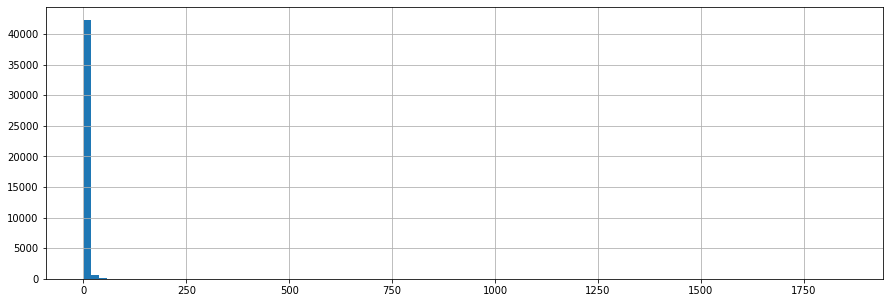

In [12]:
pair_counts['FONT_COUNT'].hist(figsize=(15,5), bins=100);

How many times does a decimal appear in a pair? Here's something interesting: font files tend to map glyphs onto lower code points (rather than the other way around)

In [13]:
dec_counts = (
    pair_counts
    .groupby('DEC')
    .size()
    .sort_values(ascending=False)
)
pd.DataFrame({
    'CHAR': dec_counts.index.map(chr),
    'COUNT': dec_counts
}).head(25)

,CHAR,COUNT
DEC,,
34,"""",266
33,!,262
35,#,260
37,%,260
36,$,259
45,-,256
61,=,256
39,',253
64,@,250


## Pair probabilities

Let's look at probabilities

In [14]:
quant = 0.95
high_quant = pairs['FONT_PROB'].quantile(quant)

print(
    "The probability that a character is a homoglyph for another:",
    f"\n+ Mean: {pairs['FONT_PROB'].mean():.02f}",
    f"\n+ Standard deviation: {pairs['FONT_PROB'].std():.02f}",
    f"\n+ Variance: {pairs['FONT_PROB'].var():.02f}",
    f"\n+ {quant} quantile: {high_quant:.02f}"
)

The probability that a character is a homoglyph for another: 
+ Mean: 0.07 
+ Standard deviation: 0.23 
+ Variance: 0.05 
+ 0.95 quantile: 0.93


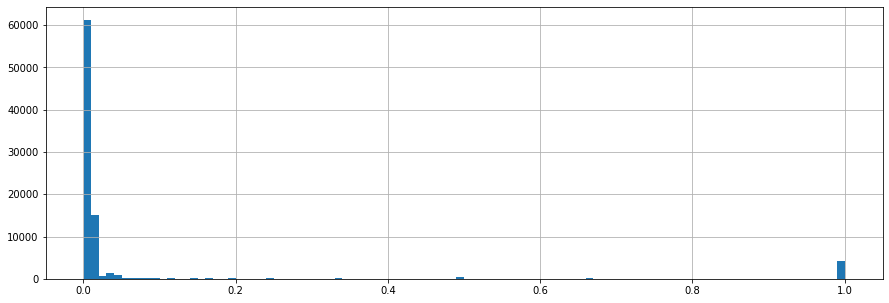

In [15]:
pairs['FONT_PROB'].hist(figsize=(15,5), bins=100);

Pairs with a probability that's one standard deviation away from the mean

In [16]:
sigma = pairs['FONT_PROB'].mean() + pairs['FONT_PROB'].std()

high_prob = pairs[pairs['FONT_PROB'] >= sigma]
high_prob = high_prob.sort_values(['FONT_PROB', 'FONT_COUNT'], ascending=False)

With `COUNT` and `PROB` in mind, some of these top pairs seem like they must consistently be homoglyphs (over and above the particularities of a single font file)

In [17]:
(high_prob
 .assign(CHAR=high_prob['DEC'].apply(chr))
 .reindex(columns=['DEC', 'PAIR', 'CHAR', 'FONT_COUNT', 'FONT_PROB'])
).head(50)

,DEC,PAIR,CHAR,FONT_COUNT,FONT_PROB
53870,1043,915,Г,190.0,1.0
67975,256,8121,Ā,113.0,1.0
43803,1263,563,ӯ,112.0,1.0
68004,298,8153,Ī,112.0,1.0
54170,222,1015,Þ,106.0,1.0
39103,1041,386,Б,104.0,1.0
68003,300,8152,Ĭ,104.0,1.0
44082,1079,604,з,98.0,1.0
53942,1136,936,Ѱ,96.0,1.0
57202,936,1136,Ψ,96.0,1.0
